# RNN作业

本次作业要求实现词性标注任务，给定一个单词，通过RNN和LSTM模型输出单词的词性。

所有数据都在data文件夹中，每个文件的命名即其词性。

请注意，为了方便比较同学们结果，**读取数据并划分数据集这部分代码不可更改**。

后续字符的编码，模型的搭建，模型的训练会给出一个参考baseline模版，同学们可以选择在此baseline模版下构建模型，
也可以选择**任意增删改**这部分代码构建自己的模型并优化.（全部删除这部分代码，自己重新写也可以)

**同学们还可以考虑用CNN提取序列特征进行分类，此部分实现并在模型评价进行对比，会得到3分的附加分。**

**如果觉得自己此部分特别优秀，可以单独写一个readme文件对自己的工作进行描述，会得到1-3分附加分。**

最后模型的评价部分要求分别输出RNN模型和LSTM模型在训练集和测试集上的正确率。**注意最终提交的版本必须已经正确显示这四个值,
如果需要助教重新跑模型得到结果，会扣除3分。**



In [1]:
#import packages
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output

## 读取数据并划分数据集（勿更改代码）

In [2]:

def findFiles(path): 
    return glob.glob(path)
tags = []
X = []
y = []


def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

for filename in findFiles('data/*.txt'):
    language = os.path.splitext(os.path.basename(filename))[0]
    if language not in tags:
        tags.append(language)
    lines = readLines(filename)
    for line in lines:
        X.append(line)
        y.append(language)

n_tags = len(tags)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =10, stratify = y)

##  字符的编码

本部分所有代码均可根据自己实现需要进行增删改，所给代码只是一种实现的参考模版。

In [3]:
# 统计字符
s = set()
for path in findFiles('data/*.txt'):
    f = open(path,"r")
    for word in f.readlines():
        for char in word:
            s.add(char)
    f.close()
all_letters = ""
for c in s:
    all_letters+=str(c)

n_letters = len(all_letters)


In [4]:
#function to create name representation

def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters)
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1
    return rep

In [5]:
#function to create lang representation

def nat_rep(lang):
    return torch.tensor([tags.index(lang)], dtype = torch.long)

In [6]:
#create a dataloader

def dataloader(batch_size, X_, y_):
    to_ret = []
    for i in range(batch_size):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_] #get the data at the random index
        to_ret.append((name, lang, name_rep(name), nat_rep(lang)))

    return to_ret


## 模型的搭建

本部分所有代码均可根据自己实现需要进行增删改，所给代码只是一种实现的参考模版。

模型需要分别构建rnn和lstm模型

In [7]:
# TODO

class RNN_net(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size=hidden_size
        self.i2h=nn.Linear(input_size+hidden_size,hidden_size)
        self.i2o=nn.Linear(input_size+hidden_size,output_size)
        self.softmax=nn.LogSoftmax(dim=1)
    
    def forward(self, input_, hidden):
        combined=torch.cat((input_,hidden),1)
        hidden=self.i2h(combined)
        output=self.i2o(combined)
        output=self.softmax(output)
        return output,hidden

    def init_hidden(self):
        return torch.zeros(1,self.hidden_size)

In [18]:
class LSTM_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.c_size=output_size
        self.wf=nn.Linear(input_size+output_size,self.c_size)
        self.sigmoid=nn.Sigmoid()
        self.wi=nn.Linear(input_size+output_size,self.c_size)
        self.wc=nn.Linear(input_size+output_size,self.c_size)
        self.tanh=nn.Tanh()
        self.wo=nn.Linear(input_size+output_size,output_size)
        self.softmax=nn.LogSoftmax(dim=1)

    def forward(self, input_, hidden_and_C):
        # c=self.C
        C=hidden_and_C[1]
        hidden=hidden_and_C[0]
        combined=torch.cat((input_,hidden),1)
        f_t=self.sigmoid(self.wf(combined))
        i_t=self.sigmoid(self.wi(combined))
        c_t_tmp=self.tanh(self.wc(combined))
        C_new=f_t*C+i_t*c_t_tmp
        output=self.sigmoid(self.wo(combined))
        hidden=output*self.tanh(C_new)
        output=self.softmax(output)
        return output,[hidden,C_new]


    def init_hidden(self):
        return [torch.zeros(1,self.c_size),torch.zeros(1,self.c_size)]

## 模型的训练


本部分所有代码均可根据自己实现需要进行增删改，所给代码只是一种实现的参考模版。

In [9]:
#function to train the data

def train_step(net, opt, criterion, batch_size):
    
    opt.zero_grad()
    total_loss = 0
    data_ = dataloader(batch_size, X_train, y_train)
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i], hidden)
            
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        total_loss += loss
        
    opt.step()     
            
    return total_loss/batch_size

In [10]:
def train(net, lr = 0.01, steps = 100, batch_size = 10, momentum = 0.9, freq = 5):

    criterion = nn.NLLLoss()  # TODO
    opt = optim.Adam(net.parameters(),lr=2e-3)      # TODO
    loss_arr = np.zeros(steps)

    #iterate through all the batches
    for i in range(steps):
        loss_arr[i] = train_step(net, opt, criterion, batch_size)
        if (i+1)%freq==0: 
            print("Iteration number:", i + 1,'Loss:', round(loss_arr[i],4))

    plt.figure()
    plt.plot(loss_arr, "-*")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()
    print("\n\n")


Iteration number: 5 Loss: 2.5078
Iteration number: 10 Loss: 2.2118
Iteration number: 15 Loss: 2.1808
Iteration number: 20 Loss: 2.1318
Iteration number: 25 Loss: 2.0085
Iteration number: 30 Loss: 1.9321
Iteration number: 35 Loss: 1.8346
Iteration number: 40 Loss: 1.7594
Iteration number: 45 Loss: 1.7335
Iteration number: 50 Loss: 1.7145
Iteration number: 55 Loss: 1.654
Iteration number: 60 Loss: 1.5128
Iteration number: 65 Loss: 1.5878
Iteration number: 70 Loss: 1.3517
Iteration number: 75 Loss: 1.3672
Iteration number: 80 Loss: 1.4224
Iteration number: 85 Loss: 1.278
Iteration number: 90 Loss: 1.3832
Iteration number: 95 Loss: 1.442
Iteration number: 100 Loss: 1.2193


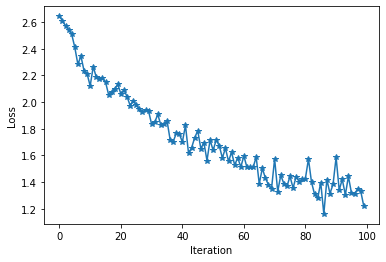

In [11]:
# rnn训练
n_hidden = 128
rnn_net = RNN_net(n_letters, n_hidden, n_tags)
train(rnn_net, lr = 0.0005, steps = 100, batch_size = 256)


Iteration number: 5 Loss: 2.6349
Iteration number: 10 Loss: 2.6296
Iteration number: 15 Loss: 2.6202
Iteration number: 20 Loss: 2.6102
Iteration number: 25 Loss: 2.604
Iteration number: 30 Loss: 2.5927
Iteration number: 35 Loss: 2.5785
Iteration number: 40 Loss: 2.5516
Iteration number: 45 Loss: 2.5222
Iteration number: 50 Loss: 2.5084
Iteration number: 55 Loss: 2.4903
Iteration number: 60 Loss: 2.4712
Iteration number: 65 Loss: 2.4415
Iteration number: 70 Loss: 2.4211
Iteration number: 75 Loss: 2.4086
Iteration number: 80 Loss: 2.434
Iteration number: 85 Loss: 2.4203
Iteration number: 90 Loss: 2.3988
Iteration number: 95 Loss: 2.4167
Iteration number: 100 Loss: 2.3956


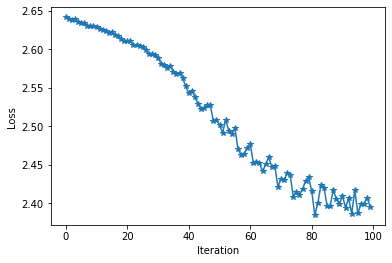

In [19]:
# lstm训练
n_hidden = 128
lstm_net = LSTM_net(n_letters, n_hidden, n_tags)
train(lstm_net, lr = 0.0005, steps = 100, batch_size = 256)


## 模型效果评价


分别输出RNN模型和LSTM模型在训练集和测试集上的正确率。**注意最终提交的版本必须已经正确显示这四个值,
如果需要助教重新跑模型得到结果，会扣除3分。**


In [13]:
def infer(net, name):
    net.eval()
    name_ohe = name_rep(name)
    hidden = net.init_hidden()

    for i in range(name_ohe.size()[0]):
        output, hidden = net(name_ohe[i], hidden)

    return output

In [14]:
#create a function to evaluate model

def eval_test(net):
     correct = 0
     for i in range(len(X_test)):
        name,lang = X_test[i],y_test[i]
        name_ohe = name_rep(name)
        lang_rep = nat_rep(lang)
        output = infer(net, name) 
        val, indices = output.topk(1) 
    
        if indices == lang_rep:
            correct += 1
     accuracy = correct/len(X_test)

     return accuracy

In [15]:
#create a function to evaluate model

def eval_train(net):
     correct = 0
     for i in range(len(X_train)):
        name,lang = X_train[i],y_train[i]
        name_ohe = name_rep(name)
        lang_rep = nat_rep(lang)
        output = infer(net, name) 
        val, indices = output.topk(1) 
    
        if indices == lang_rep:
            correct += 1
     accuracy = correct/len(X_train)

     return accuracy

In [16]:
print("rnn结果")
print("train set accuracy:"+str(round(eval_train(rnn_net),4)))
print("test set accuracy:"+str(round(eval_test(rnn_net),4)))

rnn结果
train set accuracy:0.6099
test set accuracy:0.6015


In [20]:
print("LSTM结果")
print("train set accuracy:"+str(round(eval_train(lstm_net),4)))
print("test set accuracy:"+str(round(eval_test(lstm_net),4)))

LSTM结果
train set accuracy:0.2691
test set accuracy:0.2777
